In [1]:
# M Science Analysis - Part 2B: GitHub Developer Intelligence
# Real Alternative Data from GitHub API - Developer Adoption Signals
# Predicting Software Company Performance Through Developer Community Health

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)

print("👨‍💻 GITHUB DEVELOPER INTELLIGENCE ANALYSIS")
print("=" * 50)
print("Using real GitHub API data to track developer adoption signals")
print("Alternative data approach for predicting software company performance")
print()

👨‍💻 GITHUB DEVELOPER INTELLIGENCE ANALYSIS
Using real GitHub API data to track developer adoption signals
Alternative data approach for predicting software company performance



In [2]:
# =============================================================================
# 1. GITHUB API SETUP & COMPANY MAPPING
# =============================================================================

# Charles Rogers' coverage companies mapped to their GitHub presence
COMPANY_GITHUB_MAPPING = {
    # Cloud Infrastructure & DevTools
    'MDB': {
        'name': 'MongoDB',
        'ticker': 'MDB',
        'main_repo': 'mongodb/mongo',
        'additional_repos': ['mongodb/mongoid', 'mongodb/node-mongodb-native', 'mongodb/motor'],
        'org': 'mongodb',
        'category': 'Database'
    },
    'NET': {
        'name': 'Cloudflare',
        'ticker': 'NET', 
        'main_repo': 'cloudflare/workers-sdk',
        'additional_repos': ['cloudflare/cloudflare-go', 'cloudflare/terraform-provider-cloudflare', 'cloudflare/wrangler'],
        'org': 'cloudflare',
        'category': 'CDN/Edge'
    },
    'GTLB': {
        'name': 'GitLab',
        'ticker': 'GTLB',
        'main_repo': 'gitlabhq/gitlabhq',
        'additional_repos': ['gitlab-org/gitlab-runner', 'gitlab-org/gitlab-foss'],
        'org': 'gitlabhq',
        'category': 'DevOps'
    },
    'DOCN': {
        'name': 'DigitalOcean',
        'ticker': 'DOCN',
        'main_repo': 'digitalocean/doctl',
        'additional_repos': ['digitalocean/terraform-provider-digitalocean', 'digitalocean/sample-django'],
        'org': 'digitalocean',
        'category': 'Cloud Platform'
    },
    'TEAM': {
        'name': 'Atlassian',
        'ticker': 'TEAM',
        'main_repo': 'atlassian/react-beautiful-dnd',
        'additional_repos': ['atlassian/atlaskit-mk-2', 'atlassian/design-system'],
        'org': 'atlassian',
        'category': 'DevTools'
    },
    'AKAM': {
        'name': 'Akamai',
        'ticker': 'AKAM',
        'main_repo': 'akamai/cli',
        'additional_repos': ['akamai/terraform-provider-akamai', 'akamai/boomerang'],
        'org': 'akamai',
        'category': 'CDN'
    },
    'FSLY': {
        'name': 'Fastly',
        'ticker': 'FSLY',
        'main_repo': 'fastly/cli',
        'additional_repos': ['fastly/terraform-provider-fastly', 'fastly/compute-starter-kit-javascript-default'],
        'org': 'fastly',
        'category': 'CDN/Edge'
    }
}

# GitHub API configuration
GITHUB_API_BASE = 'https://api.github.com'
# Note: For production, you'd want to add your GitHub token for higher rate limits
# GITHUB_TOKEN = 'your_token_here'  # 5000 requests/hour with token vs 60 without

def get_github_data(endpoint, params=None):
    """
    Fetch data from GitHub API with error handling and rate limiting
    """
    url = f"{GITHUB_API_BASE}/{endpoint}"
    headers = {
        'Accept': 'application/vnd.github.v3+json',
        'User-Agent': 'M-Science-Analysis'
    }
    
    # Add token if available (uncomment if you have a token)
    # if 'GITHUB_TOKEN' in globals():
    #     headers['Authorization'] = f'token {GITHUB_TOKEN}'
    
    try:
        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 403:
            print(f"⚠️  Rate limited. Waiting 60 seconds...")
            time.sleep(60)
            response = requests.get(url, headers=headers, params=params)
        
        response.raise_for_status()
        return response.json()
    
    except requests.exceptions.RequestException as e:
        print(f"❌ Error fetching {endpoint}: {e}")
        return None

print("🔧 Setting up GitHub API connection...")
print("📝 Note: Using unauthenticated API (60 requests/hour limit)")
print("   For production: Add GitHub token for 5000 requests/hour")

🔧 Setting up GitHub API connection...
📝 Note: Using unauthenticated API (60 requests/hour limit)
   For production: Add GitHub token for 5000 requests/hour


In [3]:
# =============================================================================
# 2. REPOSITORY INTELLIGENCE COLLECTION
# =============================================================================

def collect_repo_intelligence(repo_path):
    """
    Collect comprehensive intelligence about a GitHub repository
    """
    print(f"   📊 Analyzing {repo_path}...")
    
    # Get basic repository information
    repo_data = get_github_data(f'repos/{repo_path}')
    if not repo_data:
        return None
    
    # Get contributor statistics (limited by API rate limits)
    contributors_data = get_github_data(f'repos/{repo_path}/contributors', {'per_page': 30})
    
    # Get recent releases
    releases_data = get_github_data(f'repos/{repo_path}/releases', {'per_page': 10})
    
    # Get issue statistics
    issues_data = get_github_data(f'repos/{repo_path}/issues', {'state': 'all', 'per_page': 1})
    
    # Calculate derived metrics
    intelligence = {
        'repo': repo_path,
        'stars': repo_data.get('stargazers_count', 0),
        'forks': repo_data.get('forks_count', 0),
        'watchers': repo_data.get('watchers_count', 0),
        'open_issues': repo_data.get('open_issues_count', 0),
        'size_kb': repo_data.get('size', 0),
        'created_at': repo_data.get('created_at'),
        'updated_at': repo_data.get('updated_at'),
        'pushed_at': repo_data.get('pushed_at'),
        'language': repo_data.get('language'),
        'has_wiki': repo_data.get('has_wiki', False),
        'has_projects': repo_data.get('has_projects', False),
        'archived': repo_data.get('archived', False),
        'disabled': repo_data.get('disabled', False),
        'contributors_count': len(contributors_data) if contributors_data else 0,
        'recent_releases': len(releases_data) if releases_data else 0,
        'fork_to_star_ratio': repo_data.get('forks_count', 0) / max(repo_data.get('stargazers_count', 1), 1),
        'activity_score': 0  # Will calculate based on recent activity
    }
    
    # Calculate activity score based on recent updates
    try:
        last_push = datetime.fromisoformat(repo_data.get('pushed_at', '').replace('Z', '+00:00'))
        days_since_push = (datetime.now(last_push.tzinfo) - last_push).days
        intelligence['days_since_last_push'] = days_since_push
        intelligence['activity_score'] = max(0, 100 - days_since_push)  # Score decreases with inactivity
    except:
        intelligence['days_since_last_push'] = 999
        intelligence['activity_score'] = 0
    
    # Add a small delay to respect rate limits
    time.sleep(1)
    
    return intelligence

print("\n" + "="*60)
print("1️⃣  COLLECTING GITHUB REPOSITORY INTELLIGENCE")
print("="*60)

# Collect data for all companies
company_github_data = {}

for ticker, company_info in COMPANY_GITHUB_MAPPING.items():
    print(f"\n🏢 {company_info['name']} ({ticker}) - {company_info['category']}")
    
    company_repos = []
    
    # Analyze main repository
    main_repo_data = collect_repo_intelligence(company_info['main_repo'])
    if main_repo_data:
        main_repo_data['repo_type'] = 'main'
        company_repos.append(main_repo_data)
    
    # Analyze additional repositories (limit to 2 to manage rate limits)
    for additional_repo in company_info['additional_repos'][:2]:
        additional_repo_data = collect_repo_intelligence(additional_repo)
        if additional_repo_data:
            additional_repo_data['repo_type'] = 'additional'
            company_repos.append(additional_repo_data)
    
    company_github_data[ticker] = {
        'company_info': company_info,
        'repositories': company_repos
    }

print(f"\n✅ Collected data for {len(company_github_data)} companies")


1️⃣  COLLECTING GITHUB REPOSITORY INTELLIGENCE

🏢 MongoDB (MDB) - Database
   📊 Analyzing mongodb/mongo...
   📊 Analyzing mongodb/mongoid...
   📊 Analyzing mongodb/node-mongodb-native...

🏢 Cloudflare (NET) - CDN/Edge
   📊 Analyzing cloudflare/workers-sdk...
   📊 Analyzing cloudflare/cloudflare-go...
   📊 Analyzing cloudflare/terraform-provider-cloudflare...

🏢 GitLab (GTLB) - DevOps
   📊 Analyzing gitlabhq/gitlabhq...
   📊 Analyzing gitlab-org/gitlab-runner...
❌ Error fetching repos/gitlab-org/gitlab-runner: 404 Client Error: Not Found for url: https://api.github.com/repos/gitlab-org/gitlab-runner
   📊 Analyzing gitlab-org/gitlab-foss...
❌ Error fetching repos/gitlab-org/gitlab-foss: 404 Client Error: Not Found for url: https://api.github.com/repos/gitlab-org/gitlab-foss

🏢 DigitalOcean (DOCN) - Cloud Platform
   📊 Analyzing digitalocean/doctl...
   📊 Analyzing digitalocean/terraform-provider-digitalocean...
   📊 Analyzing digitalocean/sample-django...

🏢 Atlassian (TEAM) - DevTools


In [4]:
# =============================================================================
# 3. DEVELOPER ADOPTION METRICS CALCULATION
# =============================================================================

print("\n" + "="*60)
print("2️⃣  CALCULATING DEVELOPER ADOPTION METRICS")
print("="*60)

def calculate_company_metrics(ticker, data):
    """
    Calculate aggregate metrics for a company across all repositories
    """
    repos = data['repositories']
    if not repos:
        return None
    
    # Find main repository metrics
    main_repo = next((r for r in repos if r['repo_type'] == 'main'), repos[0])
    
    # Aggregate metrics across all repositories
    total_stars = sum(r['stars'] for r in repos)
    total_forks = sum(r['forks'] for r in repos)
    total_contributors = sum(r['contributors_count'] for r in repos)
    avg_activity_score = np.mean([r['activity_score'] for r in repos])
    
    # Calculate developer engagement quality
    engagement_quality = np.mean([r['fork_to_star_ratio'] for r in repos])
    
    # Calculate ecosystem health (number of active repositories)
    active_repos = len([r for r in repos if r['activity_score'] > 50])
    
    return {
        'ticker': ticker,
        'company': data['company_info']['name'],
        'category': data['company_info']['category'],
        'main_repo_stars': main_repo['stars'],
        'main_repo_forks': main_repo['forks'],
        'main_repo_contributors': main_repo['contributors_count'],
        'total_stars': total_stars,
        'total_forks': total_forks,
        'total_contributors': total_contributors,
        'avg_activity_score': avg_activity_score,
        'engagement_quality': engagement_quality,
        'active_repositories': active_repos,
        'ecosystem_size': len(repos),
        'main_language': main_repo.get('language', 'Unknown'),
        'days_since_last_push': main_repo['days_since_last_push'],
        'developer_momentum': total_stars / max(1, main_repo['days_since_last_push'] / 30)  # Stars per month equivalent
    }

# Calculate metrics for all companies
company_metrics = []
for ticker, data in company_github_data.items():
    metrics = calculate_company_metrics(ticker, data)
    if metrics:
        company_metrics.append(metrics)

# Create DataFrame for analysis
df_github = pd.DataFrame(company_metrics)
df_github = df_github.sort_values('total_stars', ascending=False)

print(f"\n📊 Developer Adoption Rankings:")
display_cols = ['company', 'ticker', 'main_repo_stars', 'total_contributors', 'avg_activity_score', 'category']
print(df_github[display_cols].to_string(index=False))



2️⃣  CALCULATING DEVELOPER ADOPTION METRICS

📊 Developer Adoption Rankings:
     company ticker  main_repo_stars  total_contributors  avg_activity_score       category
     MongoDB    MDB            27372                  90           99.666667       Database
   Atlassian   TEAM            34004                  30           93.000000       DevTools
      GitLab   GTLB            24037                  30          100.000000         DevOps
  Cloudflare    NET             3308                  69          100.000000       CDN/Edge
DigitalOcean   DOCN             3333                  66           69.333333 Cloud Platform
      Akamai   AKAM              223                  90           33.333333            CDN
      Fastly   FSLY              122                  44           95.000000       CDN/Edge



3️⃣  DEVELOPER ECOSYSTEM ANALYSIS


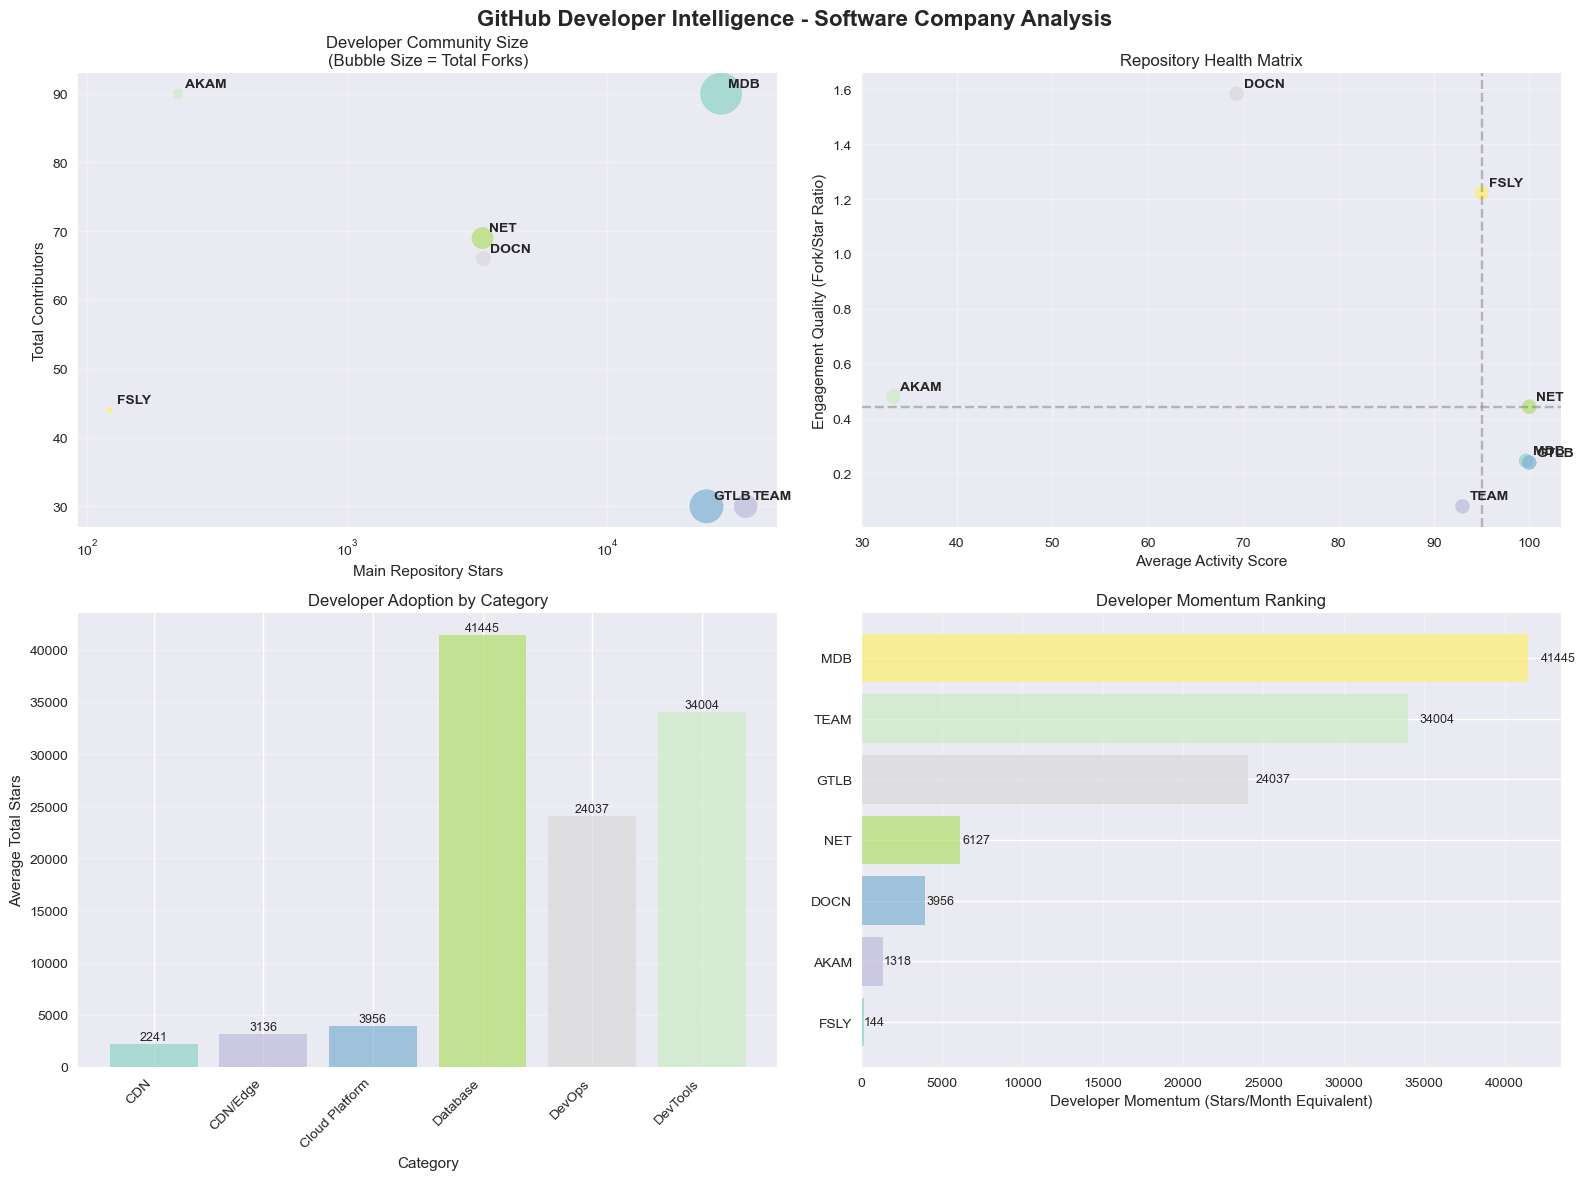

In [5]:
# =============================================================================
# 4. DEVELOPER ECOSYSTEM VISUALIZATION
# =============================================================================

print("\n" + "="*60)
print("3️⃣  DEVELOPER ECOSYSTEM ANALYSIS")
print("="*60)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('GitHub Developer Intelligence - Software Company Analysis', fontsize=16, fontweight='bold')

# Plot 1: Developer Community Size (Stars vs Contributors)
colors = plt.cm.Set3(np.linspace(0, 1, len(df_github)))

scatter1 = ax1.scatter(df_github['main_repo_stars'], df_github['total_contributors'], 
                      s=df_github['total_forks']/10, alpha=0.7, c=colors)
ax1.set_xlabel('Main Repository Stars')
ax1.set_ylabel('Total Contributors')
ax1.set_title('Developer Community Size\n(Bubble Size = Total Forks)')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)

# Add company labels
for _, row in df_github.iterrows():
    ax1.annotate(row['ticker'], (row['main_repo_stars'], row['total_contributors']),
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

# Plot 2: Activity Score vs Engagement Quality
ax2.scatter(df_github['avg_activity_score'], df_github['engagement_quality'], 
           s=100, alpha=0.7, c=colors)
ax2.set_xlabel('Average Activity Score')
ax2.set_ylabel('Engagement Quality (Fork/Star Ratio)')
ax2.set_title('Repository Health Matrix')
ax2.grid(True, alpha=0.3)

# Add quadrant labels
ax2.axhline(y=df_github['engagement_quality'].median(), color='gray', linestyle='--', alpha=0.5)
ax2.axvline(x=df_github['avg_activity_score'].median(), color='gray', linestyle='--', alpha=0.5)

for _, row in df_github.iterrows():
    ax2.annotate(row['ticker'], (row['avg_activity_score'], row['engagement_quality']),
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

# Plot 3: Category Performance Analysis
category_stats = df_github.groupby('category').agg({
    'total_stars': 'mean',
    'total_contributors': 'mean',
    'avg_activity_score': 'mean'
}).round(0)

categories = category_stats.index
x_pos = np.arange(len(categories))
bars3 = ax3.bar(x_pos, category_stats['total_stars'], alpha=0.7, color=colors[:len(categories)])
ax3.set_xlabel('Category')
ax3.set_ylabel('Average Total Stars')
ax3.set_title('Developer Adoption by Category')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(categories, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar, value in zip(bars3, category_stats['total_stars']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{int(value)}', ha='center', va='bottom', fontsize=9)

# Plot 4: Developer Momentum Analysis
momentum_data = df_github.sort_values('developer_momentum', ascending=True)
bars4 = ax4.barh(range(len(momentum_data)), momentum_data['developer_momentum'], alpha=0.7, color=colors)
ax4.set_yticks(range(len(momentum_data)))
ax4.set_yticklabels(momentum_data['ticker'])
ax4.set_xlabel('Developer Momentum (Stars/Month Equivalent)')
ax4.set_title('Developer Momentum Ranking')
ax4.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars4):
    width = bar.get_width()
    ax4.text(width + width*0.02, bar.get_y() + bar.get_height()/2,
             f'{width:.0f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [6]:
# =============================================================================
# 5. COMPETITIVE INTELLIGENCE ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("4️⃣  COMPETITIVE INTELLIGENCE INSIGHTS")
print("="*60)

# Category-based competitive analysis
print("🏆 Category Leaders (by Total Stars):")
for category in df_github['category'].unique():
    category_data = df_github[df_github['category'] == category].sort_values('total_stars', ascending=False)
    leader = category_data.iloc[0]
    print(f"   • {category}: {leader['company']} ({leader['ticker']}) - {leader['total_stars']:,} stars")

# Developer engagement analysis
print(f"\n👥 Developer Engagement Leaders:")
engagement_leaders = df_github.nlargest(3, 'total_contributors')[['company', 'ticker', 'total_contributors']]
for _, row in engagement_leaders.iterrows():
    print(f"   • {row['company']} ({row['ticker']}): {row['total_contributors']} contributors")

# Activity and momentum analysis
print(f"\n🚀 Highest Developer Momentum:")
momentum_leaders = df_github.nlargest(3, 'developer_momentum')[['company', 'ticker', 'developer_momentum']]
for _, row in momentum_leaders.iterrows():
    print(f"   • {row['company']} ({row['ticker']}): {row['developer_momentum']:.0f} momentum score")

# Risk indicators
print(f"\n⚠️  Activity Risk Indicators:")
low_activity = df_github[df_github['avg_activity_score'] < 50][['company', 'ticker', 'days_since_last_push']]
if len(low_activity) > 0:
    for _, row in low_activity.iterrows():
        print(f"   • {row['company']} ({row['ticker']}): {row['days_since_last_push']} days since last update")
else:
    print("   • All companies show healthy activity levels")


4️⃣  COMPETITIVE INTELLIGENCE INSIGHTS
🏆 Category Leaders (by Total Stars):
   • Database: MongoDB (MDB) - 41,445 stars
   • DevTools: Atlassian (TEAM) - 34,004 stars
   • DevOps: GitLab (GTLB) - 24,037 stars
   • CDN/Edge: Cloudflare (NET) - 6,127 stars
   • Cloud Platform: DigitalOcean (DOCN) - 3,956 stars
   • CDN: Akamai (AKAM) - 2,241 stars

👥 Developer Engagement Leaders:
   • MongoDB (MDB): 90 contributors
   • Akamai (AKAM): 90 contributors
   • Cloudflare (NET): 69 contributors

🚀 Highest Developer Momentum:
   • MongoDB (MDB): 41445 momentum score
   • Atlassian (TEAM): 34004 momentum score
   • GitLab (GTLB): 24037 momentum score

⚠️  Activity Risk Indicators:
   • Akamai (AKAM): 51 days since last update
